In [1]:
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
from random import randint
from matplotlib import pyplot as plt

In [2]:
import datetime
from common import get_full_data
# load data
def steel_strength():
    df = pd.read_csv("dataset/steel_strength.csv")
    # get dependent and independent features
    X=df.iloc[:,1:-3]
    y=df.iloc[:,-2]
    return get_full_data(X,y)

def renewable():
    df = pd.read_csv("dataset/Renewable.csv")
    time = df["Time"].apply(lambda x: datetime.datetime.fromisoformat(x))
    df=df.drop(columns=["Time"])
    df["month"] = time.apply(lambda t: t.month)
    df["day"] = time.apply(lambda t: t.day)
    df["hour"] = time.apply(lambda t: t.hour)
    df["minute"] = time.apply(lambda t: t.minute)
    return df.iloc[:,1:], df.iloc[:,0]

In [3]:
from xgboost import XGBRegressor
X,y = steel_strength()

# for high-dimensional data use `gpu` for device if you have one
special_model = XGBRegressor(device='cpu')

In [4]:
from sklearn.decomposition import PCA

from render import plot_3d_rgb


pca = PCA(n_components=3)
X_small = pca.fit_transform(X)
y_n = y.to_numpy()[:,np.newaxis]

X_small=np.concatenate([X_small,y_n],axis=1)
print(sum(pca.explained_variance_ratio_))
plot_3d_rgb(X_small[:40000],"render",["d1","d2","d3"])

0.9624731257052234


In [5]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from common import XGB_search_params

params = XGB_search_params()
state = randint(0,1000)
search = RandomizedSearchCV(
    special_model,
    params,
    n_iter=250,
    cv=5,
    random_state=state,
    n_jobs=-1,
)

# amount of samples used for parameters search
search_space_samples=5000

if search_space_samples>=len(X):
    search_space_samples=len(X)-1

_,X_search,_,y_search = train_test_split(X,y,test_size=search_space_samples/len(X))

search.fit(X_search,y_search)
special_model=search.best_estimator_

In [6]:
# do repeated stratified k-fold cross-validation with classification report
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold, cross_val_score
from common import cross_val_classification_report, cross_val_score_mean_std

special_model.device='cpu'

cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=50)
r2_scoring = metrics.make_scorer(metrics.r2_score)
print("r2 scoring")
cross_val_score_mean_std(cross_val_score(special_model,X,y,cv=cv,scoring=r2_scoring),y.name)

r2 scoring
-----------tensile strength-----------
Mean  0.8417106125702525
Std  0.07115121367740146


evaluate score  18564.46231477445


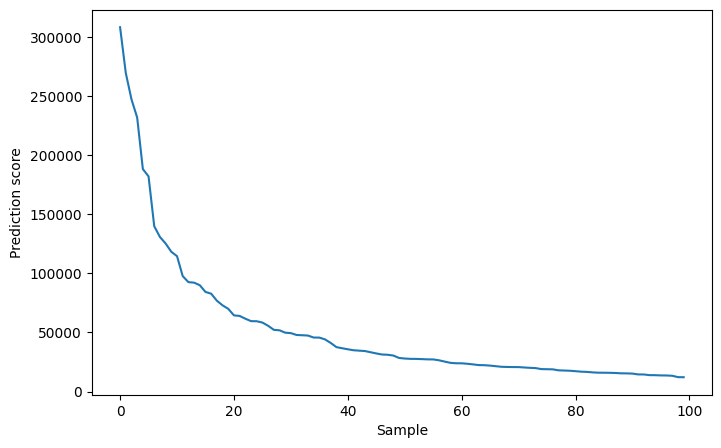

evaluate score  16788.984953974064


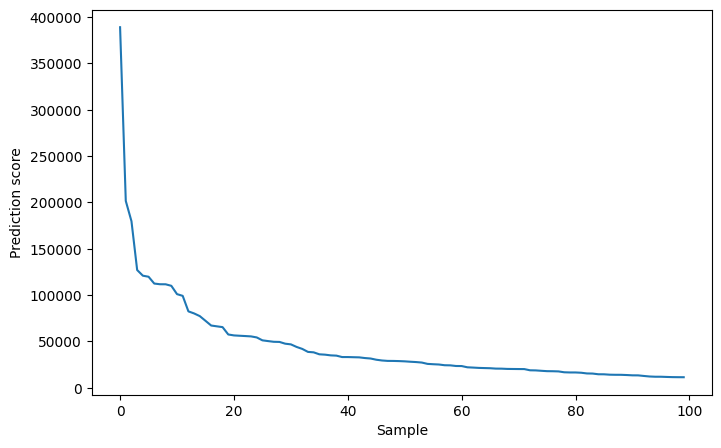

evaluate score  16003.841306136594


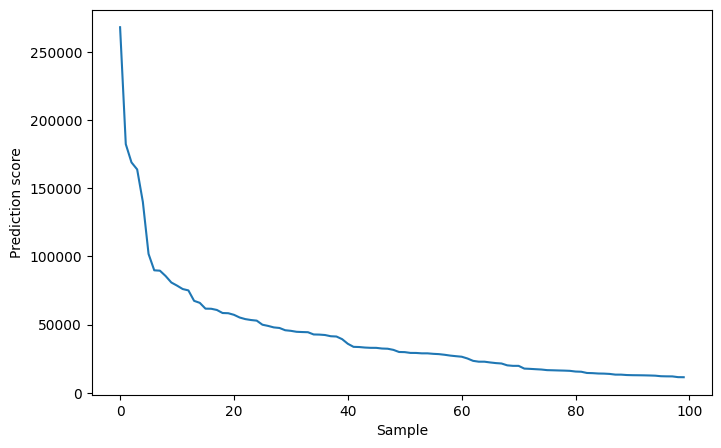

evaluate score  14541.401202627932


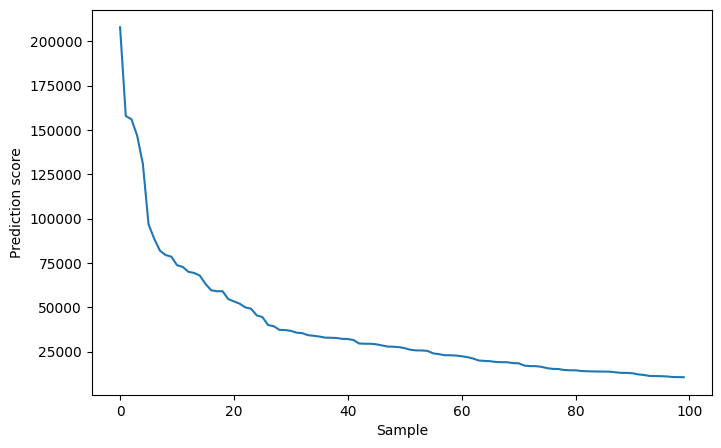

evaluate score  13274.017487386518


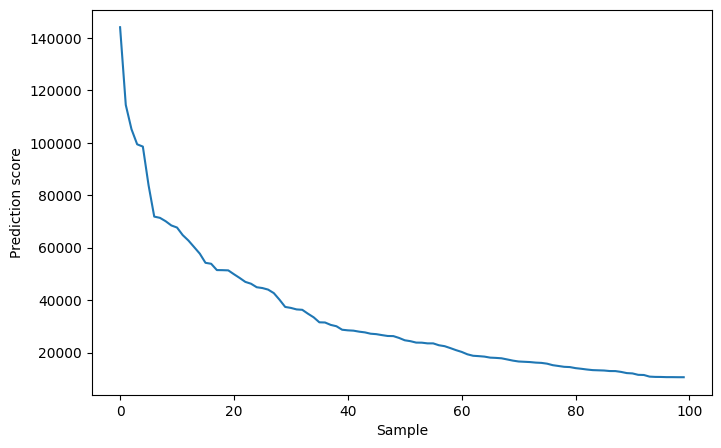

evaluate score  13055.999668527882


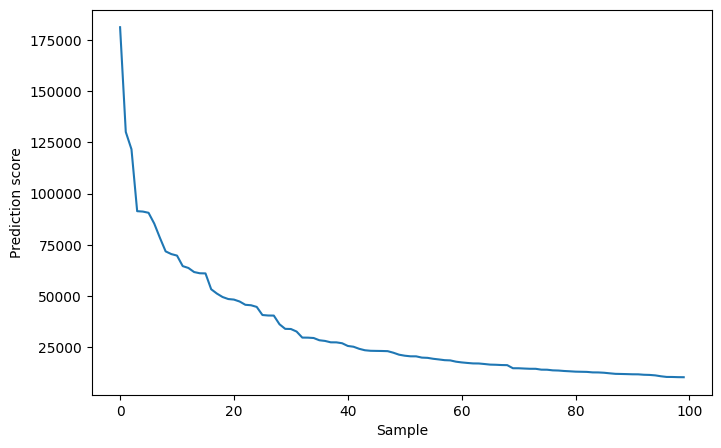

evaluate score  11761.228730168928


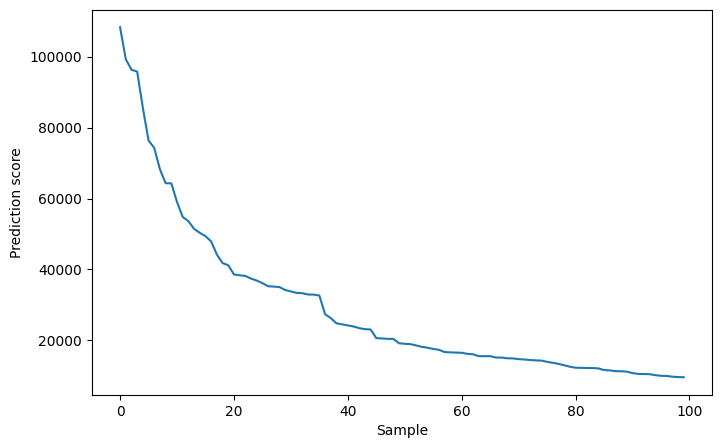

evaluate score  10957.453038640444


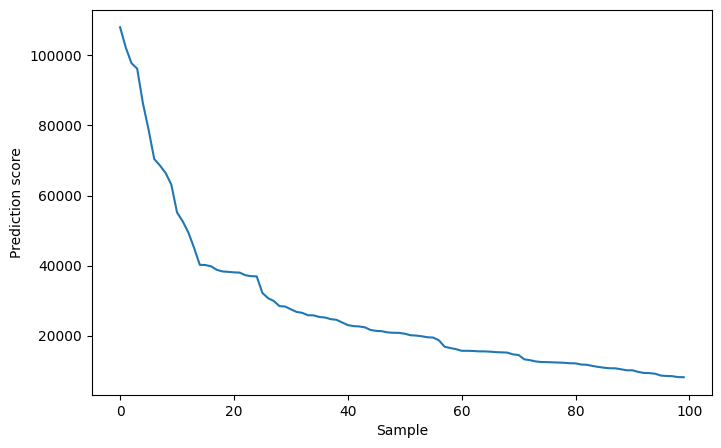

evaluate score  9930.376600211748


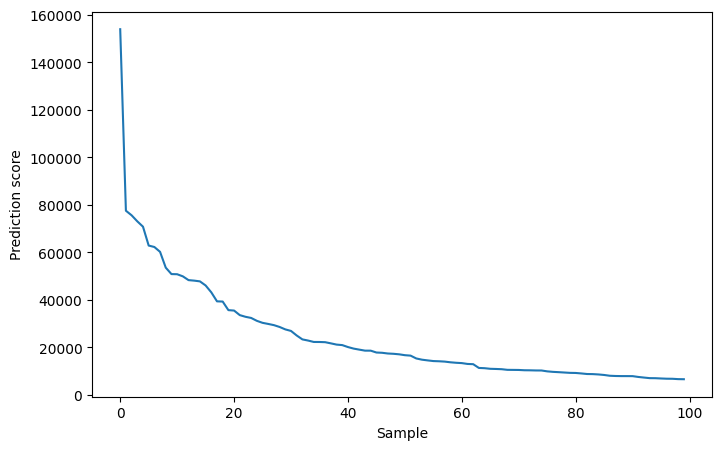

evaluate score  9203.212398472162


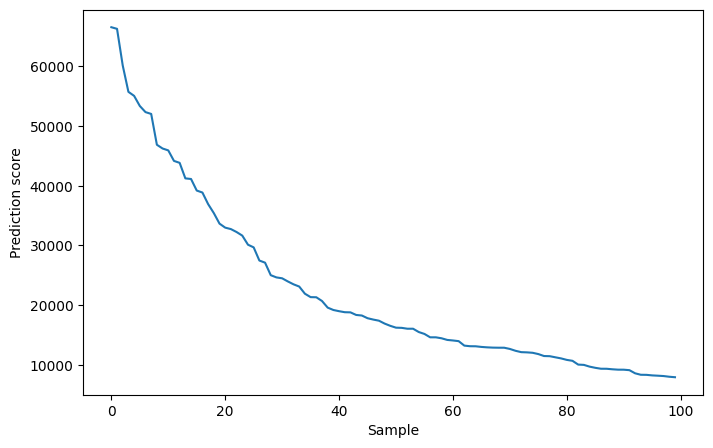

evaluate score  8060.948653925409


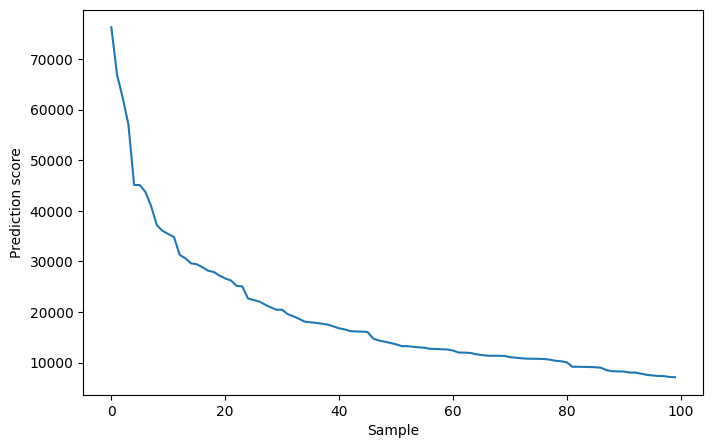

evaluate score  8443.925561325843
removed  0.09615384615384616
r2 score
-----------tensile strength-----------
Mean  0.9169185840032782
Std  0.01053831024914196


In [15]:
# New method
from common import find_outliers
X_n = X.to_numpy()
outliers, score = find_outliers(
    X_n,
    y.to_numpy(),
    special_model,
    outlier_remove_partition=0.01,
    iterations=100,
    gamma=1,
    evaluate_loss=metrics.mean_squared_error,
    cv=6,
    repeats=2,
    plot=True,
    elements_to_plot=100
)
print("removed ",len(outliers)/len(y))
X_clean = [x for i,x in enumerate(X_n) if i not in outliers]
y_clean = [y_ for i,y_ in enumerate(y) if i not in outliers]

r2_scoring = metrics.make_scorer(metrics.r2_score)
print("r2 score")
cross_val_score_mean_std(cross_val_score(special_model,X_clean,y_clean,cv=cv,scoring=r2_scoring),y.name)


In [8]:
X_small = pca.transform(X_clean)
y_n = np.array(y_clean)[:,np.newaxis]

X_small=np.concatenate([X_small,y_n],axis=1)
plot_3d_rgb(X_small[:40000],"render",["d1","d2","d3"])

/home/vlad/Programs/Programs/Git/python-outliers-detector/venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names



In [9]:
# z-score method
from scipy import stats
data = pd.concat([X,y],axis=1)
z = np.abs(stats.zscore(data))
threshold = 3
data_clean = data[(z < threshold).all(axis=1)]

X_clean=data_clean.iloc[:,:-2]
y_clean=data_clean.iloc[:,-1]

r2_scoring = metrics.make_scorer(metrics.r2_score)
print("r2 score")
cross_val_score_mean_std(cross_val_score(special_model,X_clean,y_clean,cv=cv,scoring=r2_scoring),y.name)

r2 score


-----------tensile strength-----------
Mean  0.7960493765864689
Std  0.08793104893681034


In [10]:

import pandas as pd

# Assuming 'data' is a Pandas DataFrame
Q1 = data.quantile(0.15)
Q3 = data.quantile(0.85)
IQR = Q3 - Q1
data_clean = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]

X_clean=data_clean.iloc[:,:-2]
y_clean=data_clean.iloc[:,-1]

r2_scoring = metrics.make_scorer(metrics.r2_score)
cross_val_score_mean_std(cross_val_score(special_model,X_clean,y_clean,cv=cv,scoring=r2_scoring),y.name)

-----------tensile strength-----------
Mean  0.8101430985483006
Std  0.09928293034562356


In [11]:
from sklearn.ensemble import IsolationForest


clf = IsolationForest(random_state=50)
outliers_pred=clf.fit_predict(data)

data_clean = data[outliers_pred==1]

X_clean=data_clean.iloc[:,:-2]
y_clean=data_clean.iloc[:,-1]

r2_scoring = metrics.make_scorer(metrics.r2_score)
cross_val_score_mean_std(cross_val_score(special_model,X_clean,y_clean,cv=cv,scoring=r2_scoring),y.name)

-----------tensile strength-----------
Mean  0.7912065967824906
Std  0.07322264270494437
